<html>
<div>
  <img src="https://www.engineersgarage.com/wp-content/uploads/2021/11/TCH36-01-scaled.jpg" width=360px width=auto style="vertical-align: middle;">
  <span style="font-family: Georgia; font-size:30px; color: white;"> <br/> University of Tehran <br/> AI_CA2 <br/> Spring 02 </span>
</div>
<span style="font-family: Georgia; font-size:15pt; color: white; vertical-align: middle;"> low_mist - std id: 810100186 </span>
</html>

in this notebook we are to learn about genetic algorithms and how we can use them to find results when ordinary search algorithms are not effective.

## Problem Description
in this problem we are given return and risk of investment in some companies (in a sample.csv file) and we want to find coefficients for each company so that we gain  a certain amount of profit and other constraints that are as below:
- return should at least be 1000 percent
- risk should be at most 60 percent
- we have to invest in at least 30 different companies
a sample result is given in sample_coeffs.csv file.
Since normal search algorithms wont be effective here we use genetic algorithms to find a solution. In this algorithm we start that is derived from natural selection we have an initial population which will evolve over time so that only the best survives.

## Modeling

### Consts
Since we have lots of const variables like chance of mutation and so forth, I decided to store all of them in a class.

In [39]:
from __future__ import annotations
import random
import bisect
from dataclasses import dataclass
from itertools import accumulate
import pandas as pd
from copy import deepcopy
from typing import Any, Callable, Optional
import matplotlib.pyplot as plt

@dataclass
class Consts:
    crossover_probability: int 
    mutation_probability: int
    maximum_number_of_evolutions: int
    carry_count: int
    chromosome_size: int
    return_list: list[float]
    risk_list: list[float]
    return_threshold: float
    risk_threshold: float
    num_of_investments_threshold: int
    population_size: int
    sum_of_ranks: int
    weights: list[float]
    min_investment_percent: float
    initial_percent_not_zero: float

## DataFrame
We should read csv file and store it in a data frame and then get return and risk information. 

In [40]:
CSV_ADDRESS = "assets/data/data.csv"
df = pd.read_csv(CSV_ADDRESS)

consts = Consts(
    crossover_probability = 0.6,
    mutation_probability = 0.2,
    chromosome_size = len(df["Unnamed: 0"]),
    carry_count = 80,
    maximum_number_of_evolutions = 1000,
    return_list = df["return"],
    risk_list = df["risk"],
    population_size = 400,
    return_threshold = 10,
    risk_threshold = 0.6,
    num_of_investments_threshold = 30,
    sum_of_ranks = 399 * 200,
    weights = [(i / (399 * 200)) for i in range(400)],
    min_investment_percent = 1e-12,
    initial_percent_not_zero = 0.1
)

### Chromosome
It is every individual in our population. every gene equals to a coefficient which shows how much we invest in that company. It has some useful methods like mutation, mating, etc.
- `mutate` is a function which mutates the current chromosome
- `mate` takes another chromosome and returns a new offspring of that chromosome
- `calc_fitness` in genetic algorithms we need a fitness function to calculate how good this new chromosome is 
- `normalize` will change coefficients so that the sum is 1
- `is_goal` check to see if have met the needs

In [41]:
class Chromosome:
    def __init__(self, coefficients: Optional[list[int]] = None):
        self.fitness = 0
        if coefficients is not None:
            self.coefficients = coefficients
        else: 
            self.coefficients = [random.random() if random.random() < consts.initial_percent_not_zero else 0 \
                                for _ in range(consts.chromosome_size)]
        
    def mutate(self):
        if random.random() < consts.mutation_probability:
            index = random.randint(0, consts.chromosome_size - 1)
            self.coefficients[index] = random.random()
            
        for coefficient in self.coefficients:
            if coefficient < consts.min_investment_percent:
                coefficient = 0
        
            
    def mate(self, other: Any) -> Chromosome:
        if not isinstance(other, Chromosome):
            raise ValueError("can't mate with another type")
        
        offspring_coefficients = self.coefficients
        if random.random() < consts.crossover_probability:
            crossover_point = random.randint(0, consts.chromosome_size - 1)
            if random.randint(0, 1) % 2 == 0:
                offspring_coefficients[crossover_point:] = other.coefficients[crossover_point:]
            else:
                offspring_coefficients[:crossover_point] = other.coefficients[:crossover_point] 
            
        offspring = Chromosome(offspring_coefficients) 
        return offspring
    
    def calc_return(self) -> float:
        return sum(x * y for x, y in zip(self.coefficients, consts.return_list))

    def calc_risk(self) -> float:
        return sum(i * j for i, j in zip(self.coefficients, consts.risk_list))
    
    def calc_fitness(self) -> float:
        self.normalize()
        self.fitness = self.calc_return() - self.calc_risk()
               
    def normalize(self):
        sum_of_coefficients = sum(self.coefficients)
        self.coefficients = [x / sum_of_coefficients for x in self.coefficients]
        
    def is_goal(self) -> bool:
        return sum(x * y for x, y in zip(self.coefficients, consts.return_list)) >= consts.return_threshold and \
               sum(i * j for i, j in zip(self.coefficients, consts.risk_list)) <= consts.risk_threshold and \
               len(list(i for i in self.coefficients if i != 0)) >= consts.num_of_investments_threshold
               
    def __str__(self) -> str:
        return f"coefficients are:\n{self.coefficients}\nreturn: {self.calc_return()}\nrisk: {self.calc_risk()}"
        return f"return: {self.calc_return()}, risk: {self.calc_risk()}"

## Population
The whole population which is consists of many chromosomes. It shows the world which we have now till next evolution.

In [42]:
class Population:
    def __init__(self):
        self.chromosomes = [Chromosome() for _ in range(consts.population_size)]
        self.best_fitnesses = []
        
    def found_goal(self) -> tuple[bool, Chromosome]:
        for chromosome in self.chromosomes:
            chromosome.normalize()
            if chromosome.is_goal():
                return True, chromosome
        return False, None
    
    def evolve(self):
        self.chromosomes.sort(key = lambda x: x.fitness, reverse = True)
        offsprings: list[Chromosome] = [None for _ in range(consts.population_size - consts.carry_count)]
        for i in range(len(offsprings)):
            first_parent = random.choices(self.chromosomes, consts.weights)[0]
            second_parent = random.choices(self.chromosomes, consts.weights)[0]
            offspring = first_parent.mate(second_parent)
            offspring.mutate()
            offsprings[i] = offspring
        
        self.chromosomes[consts.carry_count:] = offsprings
        
        random.shuffle(self.chromosomes)
        
    
    def genetic_algorithm(self) -> Chromosome:
        num_of_evolutions = 0
        while num_of_evolutions <= consts.maximum_number_of_evolutions:
            self.chromosomes.sort(key = lambda x: x.calc_return(), reverse = True)
            found, chromosome = self.found_goal()
            if found:
                return chromosome
            
            self.best_fitnesses.append(self.chromosomes[0].calc_return())
            self.evolve()
            num_of_evolutions += 1
        return None
    
    def plot_fitness(self):
        plt.plot(self.best_fitnesses)
        plt.xlabel('Generation')
        plt.ylabel('Best Return')
        plt.title('Best Return over Generations')
        plt.show()
 

## Example Run

In [43]:
population = Population()
    
answer = population.genetic_algorithm()
if answer is not None:
    df["coeffs"] = answer.coefficients
    df.to_csv("assets/data/result.csv")  
else:
    print("not found")

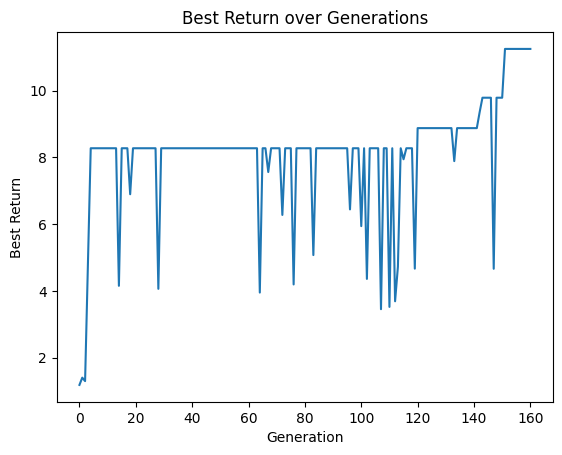

In [45]:
population.plot_fitness()

To check results we can do this

In [44]:
df2 = pd.read_csv("assets/data/result.csv")
print("return: ", sum(x * y for x, y in zip(df2["return"], df2["coeffs"])))
print("risk: ", sum(x * y for x, y in zip(df2["risk"], df2["coeffs"])))
print("num of investments: ", sum([1 for x in df2["coeffs"] if x != 0]))

return:  10.873992029645187
risk:  0.5748999290255458
num of investments:  118


## Questions

### 1. How can very large or very small population sizes affect the performance of the algorithm?  
  If the population is too small, diversity decreases and not many cases are checked in each generation. So the chances of reaching the correct solution in the same number of generations is decreased. We can make this better by increasing the mutation probability and checking more generations.  
  If the population is too large, the algorithm will take more time and resources than needed.  

### 2. What happens if the population size increases in each generation?  
  If the population grows with each generation, although the precision of the algorithm may increase because of more diversity, the time and memory consumption will increase in each step which is a problem and may reach some limitations.  
  The population size is kept the same because it is supposed to converge by populating it with the chromosomes closer to the answer and discarding the ones further away. By adding more in each step, we are not working in favor of the convergence. Also, it is unnecessary to do this because we can remove the chromosomes with the lowest fitness from the population in order to keep the population size constant.  

### 3. What is the effect of crossover and mutation? Is it possible to use only one of them?  
  Crossover will create new chromosomes by combining two chromosomes while mutation changes a chromosome directly.  
  Crossover is done with a much higher probability than mutation.  
  Crossover hopes to reach better chromosomes by combining two good chromosomes while mutation is used to escape getting stuck in a local extremum.  
  We can probably reach the solution by only using one of them but it will be most likely not efficient. But if we use only one of them, we may not be able to find the best solution. For example, if we use only crossover, we may stop at a local maximum. If we use only mutation, we may not be able to find the best solution. It is important to note that the crossover and mutation probabilities should be chosen carefully. The crossover probability is usually at least 80% and the mutation probability is usually at most 5%. 

### 4. How to accelerate the algorithm?
Fitness function, parameters such as the probability of crossover and mutation, and the population size should be chosen carefully. Also, the crossover and mutation functions can affect the performance of the algorithm. Choosing the right amount for each parameter can make the algorithm run much more efficiently.   

### 5. How to stop the algorithm if it is not converging?
A common problem in genetic algorithms is that it may stop at a local maximum instead of the global maximum. Mutation is a good way to solve this problem. Also, we can limit the number of generations in order to stop the algorithm if it is not converging. In this case, we may also use multi-start to increase the probability of finding the global maximum.  

### 6. How to stop the algorithm if there exists no solution?
We can limit the number of generations in order to stop the algorithm if there exists no solution.